In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import yfinance as yf
import re
from nltk.tokenize import word_tokenize

from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn

from transformers import AutoTokenizer
sns.set_theme(style="whitegrid")

SEED = 3

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Exploratory Data Analysis

### News Datasets

The three news datasets are obtained through [Kaggle](https://www.kaggle.com/datasets/notlucasp/financial-news-headlines/data). The author mentioned these data are scraped from CNBC, the Guardian, and Reuters official websites, the headlines in these datasets reflects the overview of the U.S. economy and stock market every day for the past year to 2 years.

The Timeframes of data:

  - Data scraped from CNBC contains the headlines, last updated date, and the preview text of articles from the end of `December 2017` to `July 19th, 2020`.
  - Data scraped from the Guardian Business contains the headlines and last updated date of articles from the end of `December 2017` to `July 19th, 2020` since the Guardian Business does not offer preview text.
  - Data scraped from Reuters contains the headlines, last updated date, and the preview text of articles from the end of `March 2018` to `July 19th, 2020`.

In [76]:
cnbc_data = pd.read_csv('dataset/cnbc_headlines.csv')

# There is ,, empty lines in CNBC, drop them
cnbc_data.dropna(subset=['Time'],inplace=True)

guardian_data = pd.read_csv('dataset/guardian_headlines.csv')
reuters_data = pd.read_csv('dataset/reuters_headlines.csv')

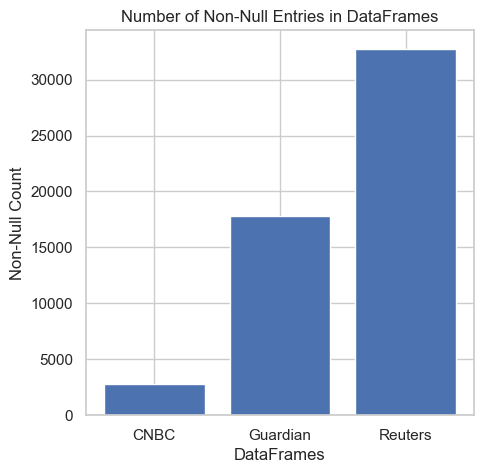

In [77]:
dfs = [cnbc_data, guardian_data, reuters_data]
df_names = ['CNBC', 'Guardian', 'Reuters']

non_null_counts = [df.dropna().shape[0] for df in dfs]

plt.figure(figsize=(5, 5))
plt.bar(df_names, non_null_counts)
plt.title("Number of Non-Null Entries in DataFrames")
plt.xlabel("DataFrames")
plt.ylabel("Non-Null Count")
plt.show()

We can see here that all of the news datasets have varying numbers of data points ranging from 2800 to 32700. This will not be a problem for us since our question focuses on the impact of news headlines in general on the S&P 500, so all of this data will be combined in to a larger dataset ordered by the date of the headline. We can also see there is null data within the CNBC dataset which will be removed. 

#### Headline Length


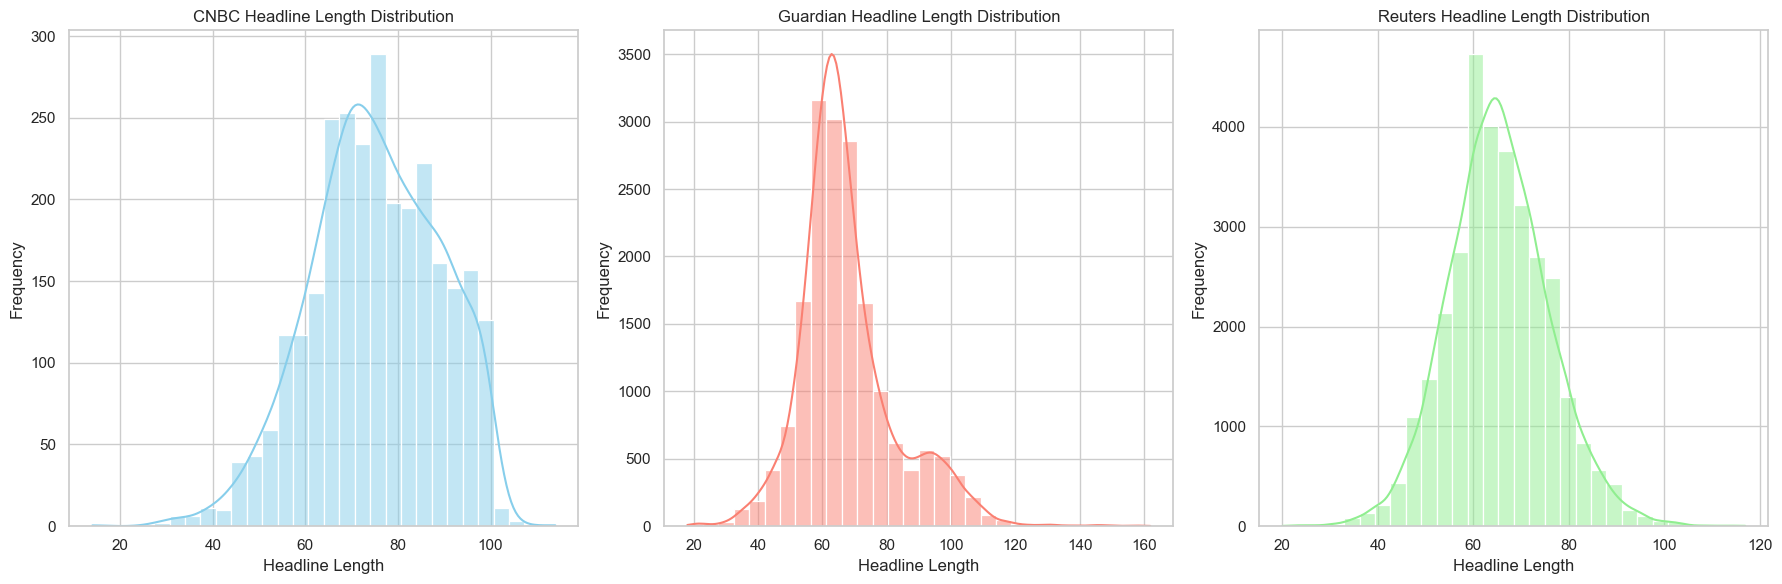

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# CNBC dataset
sns.histplot(cnbc_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[0], color="skyblue")
ax[0].set_title("CNBC Headline Length Distribution")
ax[0].set_xlabel("Headline Length")
ax[0].set_ylabel("Frequency")

# Guardian dataset
sns.histplot(guardian_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[1], color="salmon")
ax[1].set_title("Guardian Headline Length Distribution")
ax[1].set_xlabel("Headline Length")
ax[1].set_ylabel("Frequency")

# Reuters dataset
sns.histplot(reuters_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[2], color="lightgreen")
ax[2].set_title("Reuters Headline Length Distribution")
ax[2].set_xlabel("Headline Length")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


These histograms display the number of headlines given a specific length. Disregarding the bar at length of 0 in the CNBC graph due to the null data, headlines from all three stations seem to center around 60-70 words with the max being ~100 for CNBC and Reuters, and ~120 for the Guardian.

#### Headline Distribution

To find out the distribution of headlines throughout the time frame, we generated a graph with headlines colored differently in each month of the year.

In [79]:
# Extra cleaning for CNBC
cnbc_data['Time'] = (
    cnbc_data['Time']
    .str.replace(r"ET", "", regex=True)  
    .str.strip() 
    .str.replace(r"\s+", " ", regex=True)
)

In [80]:
cnbc_data['Time'] = pd.to_datetime(
    cnbc_data['Time'], format="mixed", errors='coerce'
)

# For GUARDIAN
guardian_data['Time'] = pd.to_datetime(
    guardian_data['Time'], format='%d-%b-%y', errors='coerce'
)

# For REUTERS
reuters_data['Time'] = pd.to_datetime(
    reuters_data['Time'], format='%b %d %Y', errors='coerce'
)

# Adding additional columns for time analysis
for df in [cnbc_data, guardian_data, reuters_data]:
    # Extract date parts for time-based analysis
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month

# Frequency of headlines by year and month for each dataset
cnbc_yearly_counts = cnbc_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
guardian_yearly_counts = guardian_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
reuters_yearly_counts = reuters_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)

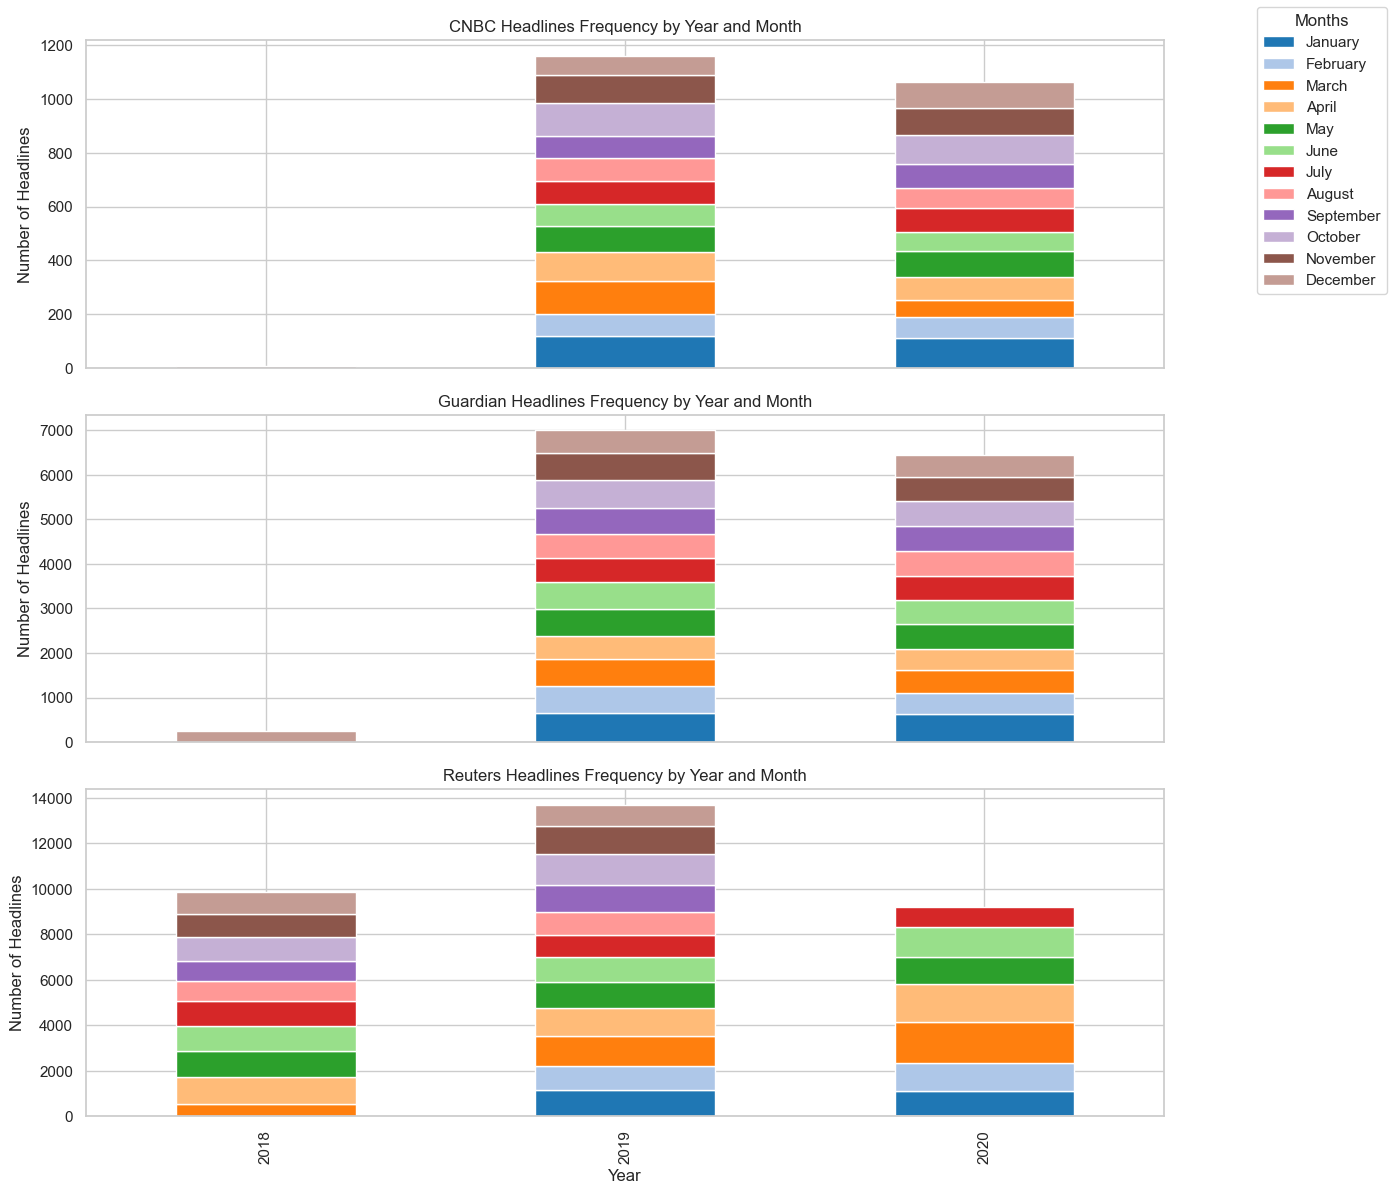

In [81]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Set a colormap to represent months consistently
month_colors = plt.colormaps["tab20"]

# CNBC dataset with month colors
cnbc_yearly_counts.plot(kind="bar", stacked=True, ax=ax[0], color=[month_colors(i) for i in range(12)], legend=False)
ax[0].set_title("CNBC Headlines Frequency by Year and Month")
ax[0].set_ylabel("Number of Headlines")

# Guardian dataset with month colors
guardian_yearly_counts.plot(kind="bar", stacked=True, ax=ax[1], color=[month_colors(i) for i in range(12)], legend=False)
ax[1].set_title("Guardian Headlines Frequency by Year and Month")
ax[1].set_ylabel("Number of Headlines")

# Reuters dataset with month colors
reuters_yearly_counts.plot(kind="bar", stacked=True, ax=ax[2], color=[month_colors(i) for i in range(12)], legend=False)
ax[2].set_title("Reuters Headlines Frequency by Year and Month")
ax[2].set_ylabel("Number of Headlines")
ax[2].set_xlabel("Year")

# Adding a single legend for the months
month_names = [calendar.month_name[i] for i in range(1, 13)]
fig.legend(month_names, loc="upper right", title="Months")
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend
plt.show()

These graphs depict the number of headlines per month per year. With this, we can see that the earlier months of the year seem to have a higher concentration of headlines. 

In [82]:
for df in [cnbc_data, guardian_data, reuters_data]:
    df.drop(columns=['Year','Month'],inplace=True)

#### Word Frequency

A short analysis on word frequency. We used the stopword dictionary in `nltk` to help filtering out words like `a` and `the`.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

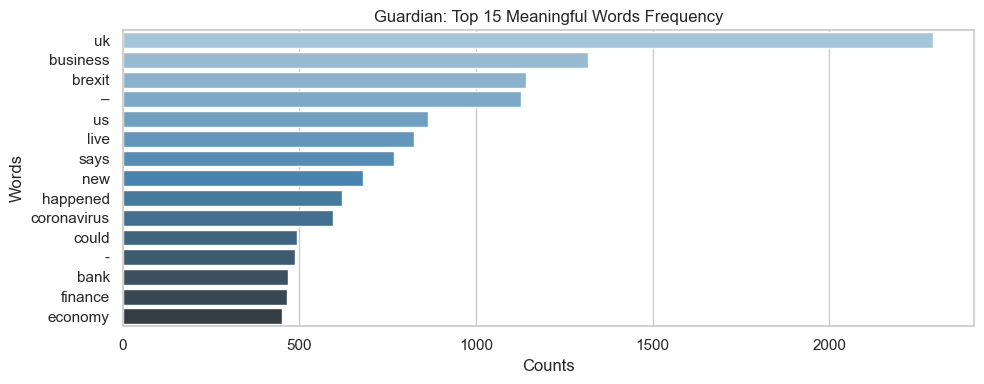

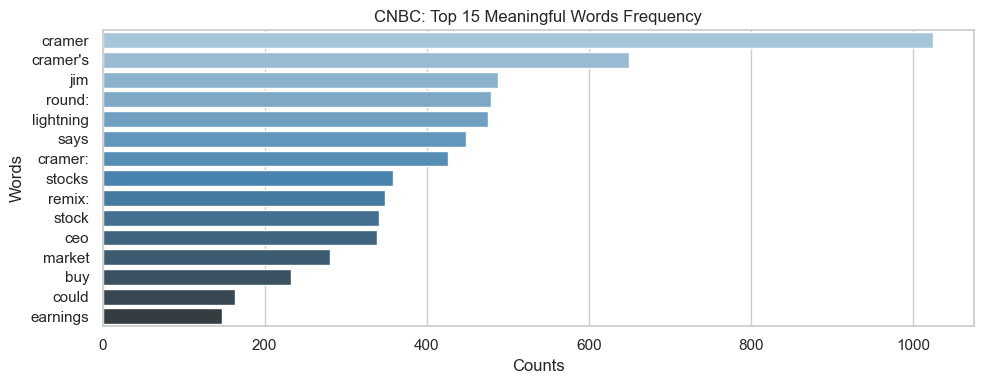

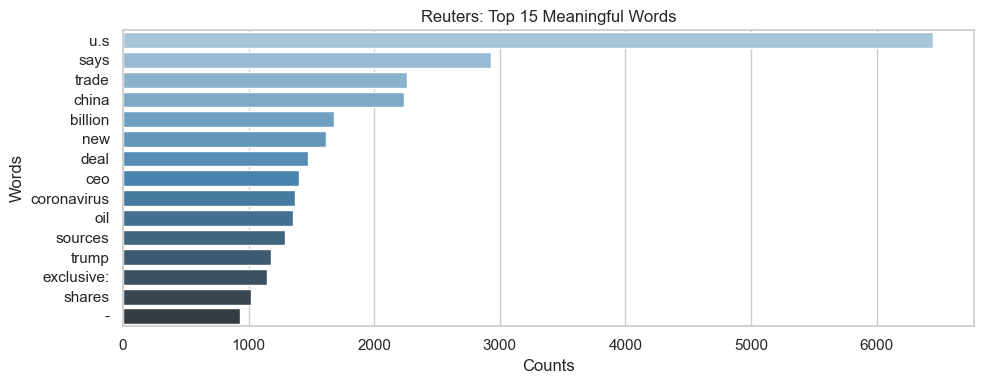

In [84]:
# Function to clean and process headlines for meaningful word frequencies
def process_and_plot(data, title, start=0, end=15, stopwords=None):
    stopwords = stop_words
    
    combined_string = ' '.join(data['Headlines'])  # Combine all headlines
    word_list = combined_string.split()  # Split into words
    word_list = [word.lower().strip(",.!?()[]") for word in word_list if word.lower() not in stopwords]
    
    # Calculate word frequencies
    word_count = Counter(word_list)
    
    # Sort words by frequency
    sorted_words = word_count.most_common()  # Sort by frequency
    top_words = sorted_words[start:end]  # Select words from the specified range
    
    # Create lists of words and their counts
    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]
    
    # Plot the bar chart
    plt.figure(figsize=(10, 4))
    sns.barplot(x=counts, y=words,hue=words, palette="Blues_d", orient="h")
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for each dataset excluding common stopwords
process_and_plot(guardian_data, 'Guardian: Top 15 Meaningful Words Frequency')
process_and_plot(cnbc_data, 'CNBC: Top 15 Meaningful Words Frequency')
process_and_plot(reuters_data, 'Reuters: Top 15 Meaningful Words')

Most of the words are meaningful, but who is `cramer` in the CNBC dataset? Turns out [Jim Cramer](https://en.wikipedia.org/wiki/Jim_Cramer) is the host of various financial programs in CNBC. We will prune him out from the CNBC dataset later.

### S&P 500 Dataset

In [85]:
ticker = "^GSPC"
start_date = "2017-12-01"
end_date = "2020-07-31"

data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
data_hlcv = data[['High', 'Low', 'Close', 'Volume']]

[*********************100%%**********************]  1 of 1 completed


#### Statistical Analysis

In [86]:
data_hlcv.describe()

,High,Low,Close,Volume
count,669.000000,669.000000,669.000000,6.690000e+02
mean,2883.568308,2849.033738,2867.277964,3.965081e+09
std,198.117998,206.057495,202.285824,1.154337e+09
min,2300.729980,2191.860107,2237.399902,1.296530e+09
25%,2739.189941,2709.540039,2724.439941,3.300220e+09
50%,2856.669922,2825.389893,2843.489990,3.635780e+09
75%,2999.149902,2970.090088,2984.870117,4.156640e+09
max,3393.520020,3378.830078,3386.149902,9.053950e+09


The S&P 500 dataset from December 1, 2017, to July 31, 2020, contains **669** daily records with columns for `High`, `Low`, `Close`, and `Volume`, with **no missing values**. The average 'High', 'Low', and 'Close' prices are around 2883, 2849, and 2867, respectively, with standard deviations near 200 points, indicating moderate volatility. The 'Volume' data, averaging 3.97 billion shares, shows considerable variability, ranging from 1.3 billion to 9.05 billion, reflecting spikes in trading activity during certain market events.

To prepare for analysis, normalization or standardization may be beneficial to handle the scale differences, particularly between price and volume data. This initial overview confirms a relatively stable daily distribution, setting up further analysis on trends, volatility, and potential event impacts on S&P 500 performance.

#### Close Price over Time

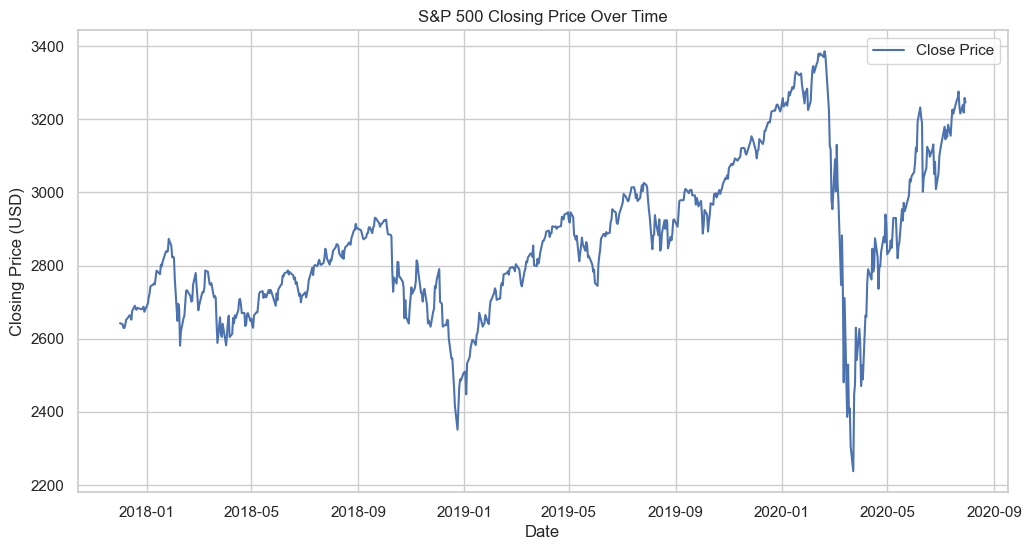

In [87]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_hlcv.index, y=data_hlcv['Close'].squeeze(), color="#4c72b0", label="Close Price")
plt.title("S&P 500 Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()

This is the stock price of the S&P 500 over min and max dates covered by the news headlines. Some noticeable features that are included in this graph is the large dip during early 2020 caused by covid. This will have an interesting impact on our model since the news did play a big role in the scare factor for COVID-19, but the fact that it was caused by a global epidemic may skew the embeddings of other words.  

## Data Preprocessing

Clean out `NaT` values in `Time` column of three datasets.

In [88]:
guardian_data.dropna(subset=['Time'], inplace=True)
cnbc_data.dropna(subset=['Time'], inplace=True)
reuters_data.dropna(subset=['Time'], inplace=True)

### Cleaning Text

Here we did our first cleaning by converting all characters to lower case, and remove extra spaces, quotation marks and other unwanted ones. We are also removing `Jim` `Cramer`, as well as his show `Mad Money` from the CNBC dataset.

In [89]:
def clean_headlines(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters except hyphens and spaces
    text = re.sub(r"[^\w\s\-]", "", text)
    words = word_tokenize(text)

    cleaned_text = " ".join(words)
    return cleaned_text


guardian_data['Headlines'] = guardian_data['Headlines'].apply(clean_headlines)

cnbc_data['Headlines'] = cnbc_data['Headlines'].apply(clean_headlines)
cnbc_data['Description'] = cnbc_data['Description'].apply(clean_headlines)

reuters_data['Headlines'] = reuters_data['Headlines'].apply(clean_headlines)
reuters_data['Description'] = reuters_data['Description'].apply(clean_headlines)

def remove_jim(text):
    words_to_remove = ['jim', 'cramer', 'mad money']

    pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'
    cleaned = re.sub(pattern, '', text, flags=re.IGNORECASE)

    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

cnbc_data['Headlines'] = cnbc_data['Headlines'].apply(remove_jim)
cnbc_data['Description'] = cnbc_data['Description'].apply(remove_jim)

cnbc_data.head()

,Headlines,Time,Description
0,a better way to invest in the covid-19 vaccine...,2020-07-17 19:51:00,host recommended buying four companies that ar...
1,cramers lightning round i would own teradyne,2020-07-17 19:33:00,host rings the lightning round bell which mean...
3,cramers week ahead big week for earnings even ...,2020-07-17 19:25:00,well pay more for the earnings of the non-covi...
4,iq capital ceo keith bliss says tech and healt...,2020-07-17 16:24:00,keith bliss iq capital ceo joins closing bell ...
5,wall street delivered the kind of pullback ive...,2020-07-16 19:36:00,look for the stocks of high-quality companies ...


### Add Prediction Target

Since our goal is to relate news outlets with S&P500, part of our project will be focusing on the trend prediction of future S&P 500 price change. Which we created a binary column `trend_up` which will be `True` if the price current trading date is lower than tomorrow's.

In [90]:
stock_data = data_hlcv.reset_index()[['Date', 'Close']]

# Flatten the column headers if they are multi-level
stock_data.columns = stock_data.columns.map(lambda x: x[1] if isinstance(x, tuple) else x)
stock_data.rename(columns={stock_data.columns[0]: 'Date', stock_data.columns[1]: 'Close'}, inplace=True)

stock_data['trend_up'] = stock_data['Close'].shift(-1) > stock_data['Close']
stock_data.head()

,Date,Close,trend_up
0,2017-12-01,2642.219971,False
1,2017-12-04,2639.439941,False
2,2017-12-05,2629.570068,False
3,2017-12-06,2629.270020,True
4,2017-12-07,2636.979980,True


We also want to make sure that the proportion `True` and `False` are balanced.

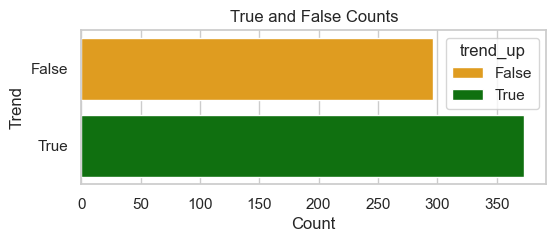

In [91]:
trend_counts = stock_data['trend_up'].value_counts()
colors = ["orange" if trend == False else "green" for trend in trend_counts.index]

plt.figure(figsize=(6, 2))
sns.barplot(
    y=trend_counts.index,
    hue=trend_counts.index,
    x=trend_counts.values,
    palette=["orange","green"],
    orient='h'
)
plt.title("True and False Counts")
plt.ylabel("Trend")
plt.xlabel("Count")
plt.yticks(ticks=[0, 1], labels=["False", "True"]) 
plt.show()

### Set Time Granularity

Though some of the datasets has timestamp with minute-wise precisions, we only want to research on a daily basis.

In [92]:
guardian_data['Date'] = pd.to_datetime(guardian_data['Time']).dt.date
cnbc_data['Date'] = pd.to_datetime(cnbc_data['Time']).dt.date
reuters_data['Date'] = pd.to_datetime(reuters_data['Time']).dt.date

guardian_data.drop(columns=['Time'],inplace=True)
cnbc_data.drop(columns=['Time'],inplace=True)
reuters_data.drop(columns=['Time'],inplace=True)

stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

### Concatenate 3 New Datasets

For our first model, we will ignore temporal relationship by treating every news as an independent datapoint. We merged all datasets into one, along with the prediction target.

In [93]:
# Concatenate datasets with stock data
cnbc_merged = pd.merge(cnbc_data, stock_data, on='Date', how='inner')
cnbc_merged['Source'] = 'CNBC'
guardian_merged = pd.merge(guardian_data, stock_data, on='Date', how='inner')
guardian_merged['Source'] = 'Guardian'
reuters_merged = pd.merge(reuters_data, stock_data, on='Date', how='inner')
reuters_merged['Source'] = 'Reuters'

# Combine all datasets into one
first_model_data = pd.concat([cnbc_merged, guardian_merged, reuters_merged])

first_model_data.to_csv("dataset/first_model_data.csv", index=False) 
first_model_data.head()

,Headlines,Description,Date,Close,trend_up,Source
0,a better way to invest in the covid-19 vaccine...,host recommended buying four companies that ar...,2020-07-17,3224.729980,True,CNBC
1,cramers lightning round i would own teradyne,host rings the lightning round bell which mean...,2020-07-17,3224.729980,True,CNBC
2,cramers week ahead big week for earnings even ...,well pay more for the earnings of the non-covi...,2020-07-17,3224.729980,True,CNBC
3,iq capital ceo keith bliss says tech and healt...,keith bliss iq capital ceo joins closing bell ...,2020-07-17,3224.729980,True,CNBC
4,wall street delivered the kind of pullback ive...,look for the stocks of high-quality companies ...,2020-07-16,3215.570068,True,CNBC


## Base Model

We are using logistic regression with TF-IDF features as our base model.

### Individual Headline Model

For this model, we are treating every news are individual data points. This is guarantee to fail because there is way to little information contained in a single news title, and there will be too much noise.

In [95]:
data = first_model_data[['Headlines', 'trend_up']].copy()

vectorizer = TfidfVectorizer(max_features=300) 
X = vectorizer.fit_transform(data['Headlines']).toarray()
y = data['trend_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=SEED)


model = LogisticRegression(random_state=SEED, max_iter=1500)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

data.to_csv("./dataset/single_dataset.csv",index=False)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("Report on test dataset:")
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()

Test Accuracy: 0.5147572199301809
Train Accuracy: 0.5766158891357241
Report on test dataset:


,precision,recall,f1-score,support
False,0.443804,0.033861,0.062921,4548.000000
True,0.517461,0.960652,0.672614,4905.000000
accuracy,0.514757,0.514757,0.514757,0.514757
macro avg,0.480633,0.497257,0.367768,9453.000000
weighted avg,0.482023,0.514757,0.379281,9453.000000


### Joint Headline Model

By joining all headlines of the same day in to one sentence, we hope that TF-IDF could capture more information than our previous model.

In [21]:
grouped_dataset = first_model_data.groupby('Date').agg(
    Headlines=('Headlines', ' '.join), 
    trend_up=('trend_up', 'first') 
).reset_index()

grouped_dataset.to_csv("./dataset/grouped_dataset.csv")
grouped_dataset.head()

,Date,Headlines,trend_up
0,2017-12-18,france saves marquis de sades 120 days of sodo...,False
1,2017-12-19,house prices to fall in london and south-east ...,False
2,2017-12-20,hedge funds fail to stop billion-dollar brain ...,True
3,2017-12-21,guardian brexit watch brexit helped push down ...,False
4,2017-12-22,says owning too many stocks and too little cas...,False


In [22]:
data = grouped_dataset[['Headlines', 'trend_up']].copy()

vectorizer = TfidfVectorizer(max_features=200)
X = vectorizer.fit_transform(data['Headlines']).toarray()
y = data['trend_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=SEED)


model = LogisticRegression(random_state=SEED, max_iter=1500)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("Report on test dataset:")
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()

Test Accuracy: 0.5461538461538461
Train Accuracy: 0.6421663442940039
Report on test dataset:


,precision,recall,f1-score,support
False,0.333333,0.035088,0.063492,57.000000
True,0.556452,0.945205,0.700508,73.000000
accuracy,0.546154,0.546154,0.546154,0.546154
macro avg,0.444892,0.490147,0.382000,130.000000
weighted avg,0.458623,0.546154,0.421201,130.000000


We also experimented in the amount of features TF-IDF should have in order to have the best performance.

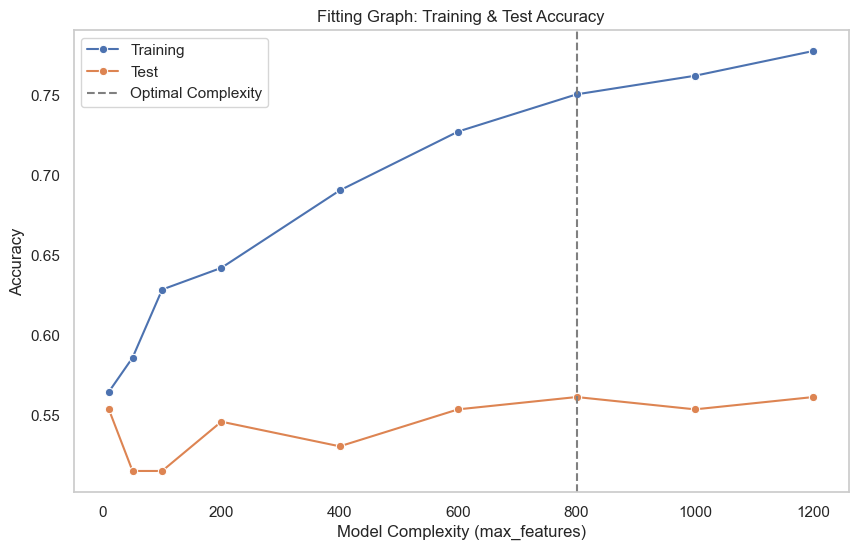

In [23]:
complexities = [10, 50, 100, 200, 400, 600, 800, 1000, 1200]

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

for max_features in complexities:
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(data['Headlines']).toarray()
    y = data['trend_up']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=SEED)
    
    model = LogisticRegression(random_state=SEED, max_iter=1500)
    model.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


plot_data = pd.DataFrame({
    'Complexity': complexities * 2,
    'Accuracy': train_accuracies + test_accuracies,
    'Type': ['Training'] * len(complexities) + ['Test'] * len(complexities)
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='Complexity', y='Accuracy', hue='Type', marker='o')
plt.axvline(x=complexities[np.argmax(test_accuracies)], linestyle='--', color='gray', label="Optimal Complexity")
plt.title("Fitting Graph: Training & Test Accuracy")
plt.xlabel("Model Complexity (max_features)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

As expected, we do not need to high complexity for TF-IDF, as increasing it will overfit our training dataset. A complexity around 800 yields the best result on the test set with accuracy about 55%.

## Transformer Model

We will be using our joined dataset which concatenate all news in the same day to one line. The main reason for this is because if we use single data news data points, there will be too much noise in our dataset, and the model cannot learn any features. Notice that `shuffle` is set to `False` in our split. This is because the stock and news data are all time-series, which we cannot inform our model about the future.

In [24]:
data = pd.read_csv("./dataset/grouped_dataset.csv")
train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=False, random_state=SEED)

### Preparation
We used a tokenizer from HuggingFace, which give unique tokens to every word.

In [25]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The `Dataset` class to create PyTorch's data loader.

In [26]:
# Class that containerizes the dataset
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_length):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        # Tokenize individual headline
        text = self.headlines[idx]
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return tokens['input_ids'].squeeze(0), torch.tensor(self.labels[idx], dtype=torch.float)
        
# Create the test and train data loaders from data
def createDataLoader(train_data, test_data, tokenizer, MAX_LENGTH, BATCH_SIZE):
    train_PYdataset = NewsDataset(
        headlines=train_data['Headlines'].tolist(),
        labels=train_data['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    train_dataloader = DataLoader(
        train_PYdataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
    )


    test_PYdataset = NewsDataset(
        headlines=test_data['Headlines'].tolist(),
        labels=test_data['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    test_dataloader = DataLoader(
        test_PYdataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    return train_dataloader, test_dataloader



The module is a custom classifier from PyTorch. We will be utilizing the `TransformerEncoderLayer`, as our prediction class is only using the encoder. After the encoder, we added a fully connected layer so the output will be `num_output` of `logits`.

In [27]:
# An untrained transformer class with multiple hyperparameters
class UntrainedTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, max_length, num_output, dropout = 0.2):
        super(UntrainedTransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Embedding(max_length,embed_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        #
        self.linear = nn.Linear(embed_dim, num_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)

        # Token embedding + positional encoding
        x = self.embedding(input_ids) + self.positional_encoding(torch.arange(seq_length,device=input_ids.device))

        x = self.transformer(x)

        x = self.dropout(x)
        x = x.max(dim=1)[0]
        out = self.linear(x)
        return out   


Below are some helper methods for calculating evaluation metrics and graphs.

In [28]:
# Evalutation method for single class
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, Y in dataloader:
            input_ids = X.to(device)
            labels = Y.to(device)

            logits = model(input_ids)
            outputs = torch.sigmoid(logits).squeeze(1)


            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct / total_samples
    model.train()
    return accuracy

#Evaluation method for two classes
def evaluate_old(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for X,Y in dataloader:
            input_ids = X.to(device)  # Move to device
            labels = Y.to(device)        # Move to device


            logits = model(input_ids)
            # Calculate predictions
            _,preds = torch.max(logits.data, 1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)


    accuracy = correct / total_samples
    model.train()
    return accuracy
# Generates the fitting graph given test and train error
def generateFittingGraph(train_error, test_error, epochs):
    x = range(1,epochs+1)
    plt.plot(x, train_error, label="Train Error")
    plt.plot(x, test_error, label="Test Error")
    
    plt.xlabel("Epochs")
    plt.ylabel("Predictive Error")
    plt.title("Fitting Graph")

    plt.legend()
    plt.show()

### Base Classifier Transformer Model

To start, we are using the following hyperparameters.

In [ ]:
#| code-fold: false
MAX_LENGTH = 600
BATCH_SIZE = 16
EMBED_DIM = 128
NUM_HEAD = 4
NUM_LAYER = 6
NUM_OUTPUT = 2
EPOCHS = 25
LEARNING_RATE = 1e-4

c:\Users\Aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [5/25], Loss: 0.6124, Train Acc: 0.6615, Test Acc: 0.5000
Epoch [10/25], Loss: 0.5535, Train Acc: 0.5919, Test Acc: 0.5615
Epoch [15/25], Loss: 0.5094, Train Acc: 0.9439, Test Acc: 0.4769
Epoch [20/25], Loss: 0.3591, Train Acc: 0.9884, Test Acc: 0.5000
Epoch [25/25], Loss: 0.3440, Train Acc: 0.9923, Test Acc: 0.5385


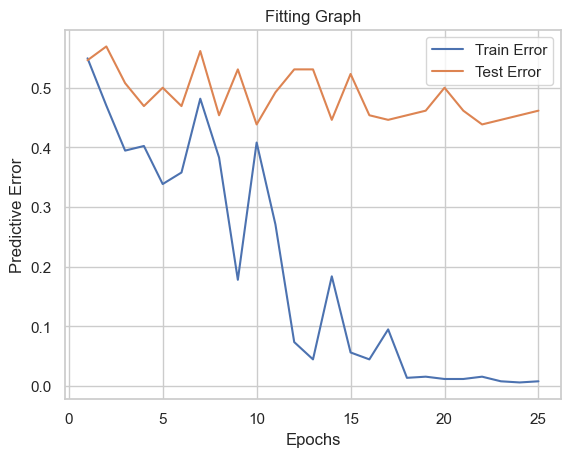

In [30]:
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model_base = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model_base.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        yb = yb.type(torch.LongTensor)
        xb, yb = xb.to(device), yb.to(device)

        logits = model_base(xb)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainErr = evaluate_old(model_base, train_dataloader, device)    
    testErr = evaluate_old(model_base, test_dataloader, device) 
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

generateFittingGraph(train_error, test_error, EPOCHS)

As we can tell, the test accuracy is around 50%, which means the model did not learn anything useful and ended up guessing randomly. We are not using a model which does nothing more than just coin-flipping, so we did more hyperparameter tunning.

### Changing to Singular Class

Since we are doing binary classification, there is no need for the output to be two classes, we can just merge it into one class.

In [31]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 4
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

Epoch [5/25], Loss: 0.7740, Train Acc: 0.5629, Test Acc: 0.5538
Epoch [10/25], Loss: 0.7029, Train Acc: 0.6402, Test Acc: 0.4923
Epoch [15/25], Loss: 0.6256, Train Acc: 0.6983, Test Acc: 0.5000
Epoch [20/25], Loss: 0.6154, Train Acc: 0.7737, Test Acc: 0.4769
Epoch [25/25], Loss: 0.6474, Train Acc: 0.8162, Test Acc: 0.5231


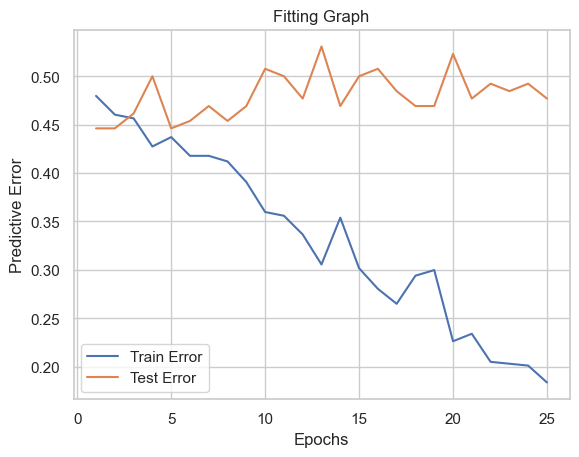

In [32]:
train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=False, random_state=SEED)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model_one = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_one.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model_one(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model_one, train_dataloader, device)    
    testErr = evaluate(model_one, test_dataloader, device) 

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)
    
generateFittingGraph(train_error, test_error, EPOCHS)

### Removing Stop Words

In [59]:
data_clean = data.copy()

data_clean['Headlines'] = data_clean['Headlines'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
data_clean['Headlines'] = data_clean['Headlines'].apply(lambda x: [word for word in x if word not in stop_words])

i=0
for headline in data_clean['Headlines']:
    new_headline = ' '.join(headline)
    data_clean.loc[i, 'Headlines'] = new_headline
    i+=1

In [60]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 4
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

Epoch [5/25], Loss: 0.7025, Train Acc: 0.5725, Test Acc: 0.6154
Epoch [10/25], Loss: 0.6257, Train Acc: 0.6518, Test Acc: 0.6231
Epoch [15/25], Loss: 0.5229, Train Acc: 0.6905, Test Acc: 0.6000
Epoch [20/25], Loss: 0.7097, Train Acc: 0.7079, Test Acc: 0.6077
Epoch [25/25], Loss: 0.5669, Train Acc: 0.7427, Test Acc: 0.6077


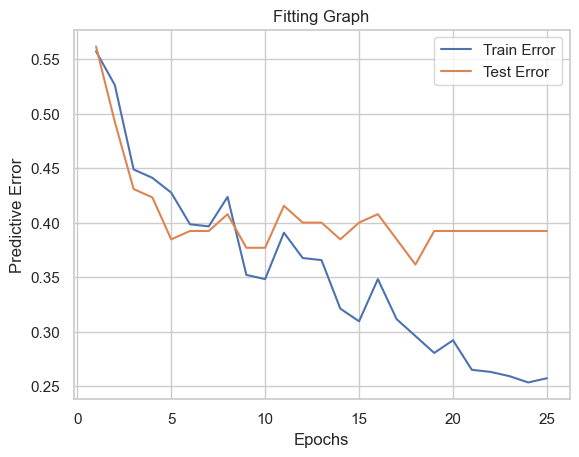

In [61]:
train_dataset, test_dataset = train_test_split(data_clean, test_size=0.2, shuffle=False, random_state=SEED)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model_rm1 = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_rm1.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model_rm1(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model_rm1, train_dataloader, device)    
    testErr = evaluate(model_rm1, test_dataloader, device) 

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)
    
generateFittingGraph(train_error, test_error, EPOCHS)

### Removing Specific Words (remix, cramers lightning round)

In [62]:
def clean_headlines(text):
    words_to_remove = ['remix', 'cramers lightning round']

    pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'
    cleaned = re.sub(pattern, '', text, flags=re.IGNORECASE)

    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

data_clean_cramer = data.copy()
data_clean_cramer['Headlines'] = data_clean_cramer['Headlines'].apply(clean_headlines)

In [63]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 4
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

Epoch [5/25], Loss: 0.6566, Train Acc: 0.5725, Test Acc: 0.5385
Epoch [10/25], Loss: 0.6646, Train Acc: 0.5977, Test Acc: 0.5692
Epoch [15/25], Loss: 0.6579, Train Acc: 0.6170, Test Acc: 0.5615
Epoch [20/25], Loss: 0.7210, Train Acc: 0.6480, Test Acc: 0.5692
Epoch [25/25], Loss: 0.5859, Train Acc: 0.7292, Test Acc: 0.5462


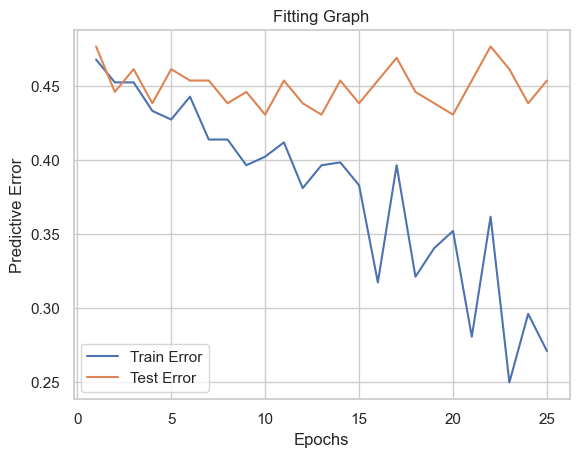

In [64]:
train_dataset, test_dataset = train_test_split(data_clean_cramer, test_size=0.2, shuffle=False, random_state=SEED)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model_rm2 = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_rm2.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model_rm2(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model_rm2, train_dataloader, device)    
    testErr = evaluate(model_rm2, test_dataloader, device) 

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)
    
generateFittingGraph(train_error, test_error, EPOCHS)

### Increasing number of heads

In [ ]:
#| code-fold: false
MAX_LENGTH = 300
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 16
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

Epoch [5/25], Loss: 0.6907, Train Acc: 0.5706, Test Acc: 0.5538
Epoch [10/25], Loss: 0.7336, Train Acc: 0.6499, Test Acc: 0.5077
Epoch [15/25], Loss: 0.7047, Train Acc: 0.7060, Test Acc: 0.5385
Epoch [20/25], Loss: 0.5875, Train Acc: 0.7776, Test Acc: 0.5077
Epoch [25/25], Loss: 0.6778, Train Acc: 0.8472, Test Acc: 0.4769


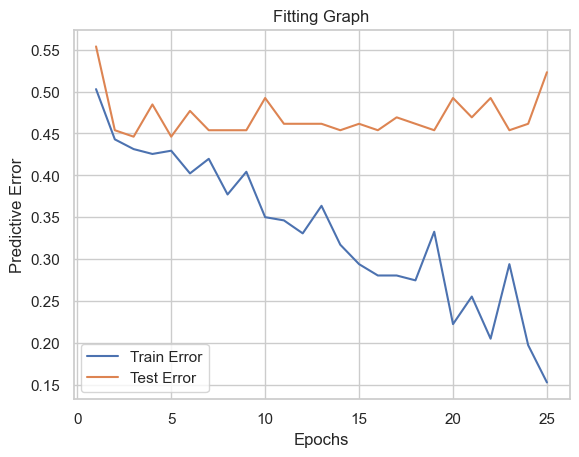

In [52]:
train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=False, random_state=SEED)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model_moreHead = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_moreHead.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model_moreHead(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model_moreHead, train_dataloader, device)    
    testErr = evaluate(model_moreHead, test_dataloader, device) 

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)
    
generateFittingGraph(train_error, test_error, EPOCHS)

### Increasing Number of Heads with LR Decay

In [41]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 32
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

Epoch [5/25], Loss: 0.6720, Train Acc: 0.6054, Test Acc: 0.4923
Epoch [10/25], Loss: 0.6274, Train Acc: 0.6190, Test Acc: 0.5231
Epoch [15/25], Loss: 0.7014, Train Acc: 0.6402, Test Acc: 0.5000
Epoch [20/25], Loss: 0.6835, Train Acc: 0.6422, Test Acc: 0.5077
Epoch [25/25], Loss: 0.5104, Train Acc: 0.6499, Test Acc: 0.5077


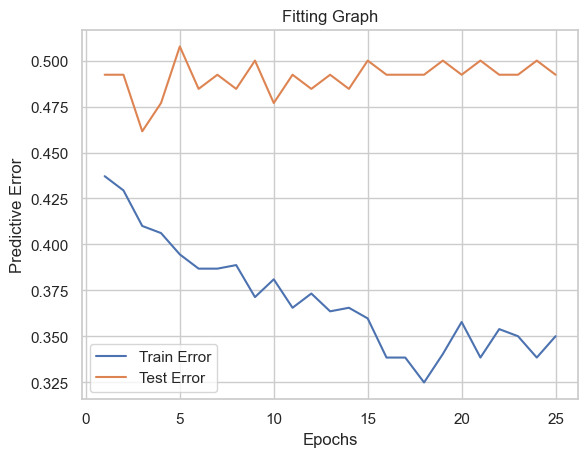

In [42]:
train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=False, random_state=SEED)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model_LR = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_LR.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model_LR(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    trainErr = evaluate(model_LR, train_dataloader, device)    
    testErr = evaluate(model_LR, test_dataloader, device) 

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)
    
generateFittingGraph(train_error, test_error, EPOCHS)

### Conclusion and Best Model

Our best results happened to be 60% accuracy when we removed stop words. Usually for context analysis, we should not remove stop words, but it maybe that stop words in news headlines are uninformative compared with other words.

In [70]:
model = model_rm1

model.eval()
correct = 0
total_samples = 0
FP = 0  # False Positives
FN = 0  # False Negatives
TP = 0  # True Positives
TN = 0  # True Negatives

with torch.no_grad():
    for X, Y in train_dataloader:
        input_ids = X.to(device)
        labels = Y.to(device)

        logits = model(input_ids)
        outputs = torch.sigmoid(logits).squeeze(1)

        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()

        TP += ((preds == 1) & (labels == 1)).sum().item()
        TN += ((preds == 0) & (labels == 0)).sum().item()
        FP += ((preds == 1) & (labels == 0)).sum().item()
        FN += ((preds == 0) & (labels == 1)).sum().item()

        total_samples += labels.size(0)

# Print results
print(f"Total Samples: {total_samples}. Correct: {correct}, True Positive: {TP}, True Negative: {TN}. False Positive: {FP}, False Negative: {FN}.")


Total Samples: 517. Correct: 273, True Positive: 238, True Negative: 35. False Positive: 194, False Negative: 50.


Our model did relatively well on predicting, with very few false negatives, which we can take advantage of it.

## Quantitative Trading Strategy

Before we make our strategy, lets visualize how our model performs on the training dataset.

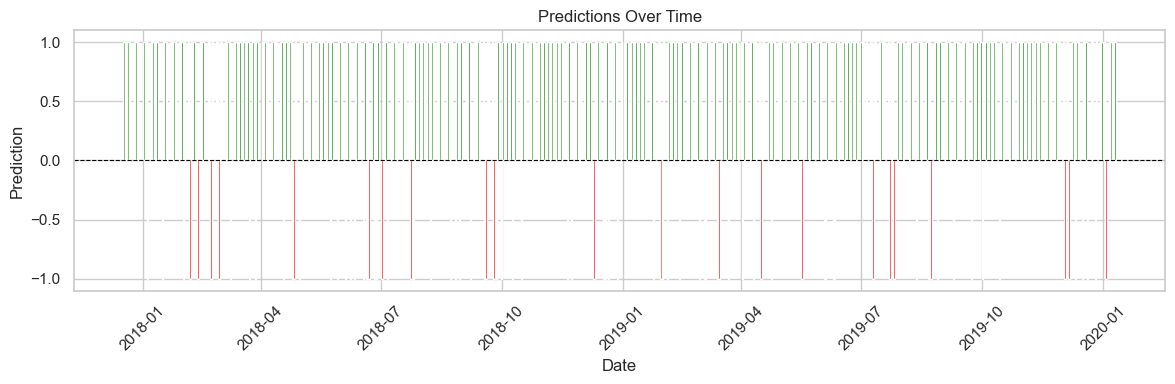

In [65]:
model = model_rm1

def visualize_predictions(date,predictions):
    chart_data = pd.DataFrame({
        "Date": date,
        "Prediction": [1 if pred else -1 for pred in predictions]  # +1 for True, -1 for False
    })

    chart_data["Date"] = pd.to_datetime(chart_data["Date"])
    chart_data.sort_values("Date", inplace=True)

    plt.figure(figsize=(12, 4))
    plt.bar(chart_data["Date"], chart_data["Prediction"], 
            color=chart_data["Prediction"].map({1: "green", -1: "red"}),
            width=1.0)  # Adjust width for better appearance

    plt.xlabel("Date")
    plt.ylabel("Prediction")
    plt.title("Predictions Over Time")
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")  # Add a horizontal line at 0
    plt.xticks(rotation=45)  # Rotate date labels for readability

    plt.tight_layout()
    plt.show()

train_dataset_quant = NewsDataset(
        headlines=train_dataset['Headlines'].tolist(),
        labels=train_dataset['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )

train_dataloader_quant = DataLoader(
    train_dataset_quant, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model.eval()
correct = 0
total_samples = 0
FP = 0  # False Positives
FN = 0  # False Negatives
TP = 0  # True Positives
TN = 0  # True Negatives

predictions = []

with torch.no_grad():
    for X, Y in train_dataloader_quant:
        input_ids = X.to(device)
        labels = Y.to(device)

        logits = model(input_ids)
        outputs = torch.sigmoid(logits).squeeze(1)

        preds = (outputs >= 0.5)

        predictions.extend(preds.cpu().numpy().astype(bool))

visualize_predictions(train_dataset["Date"],predictions)

From the graph above, we know that most of the time our model is predicting `true`. We can utilize it because from our previous section, we know that our model has very few false negatives, so we can be certain that most of the times the model is able to predict upcoming downfalls of the index. So we can make our strategy as the following:

- Hold until model predicts bear market
- When we detect bears, sell 80% and do a short with the revenue for 3 days

Now we try to simulate it on the test dataset. We are using [Vanguard's S&P500 ETF (VOO)](https://investor.vanguard.com/investment-products/etfs/profile/voo#overview) as our target since ETFs reflects the asset with very short lags, which is enough as we are not doing high-frequency trading.

In [66]:
test_dataset_quant = NewsDataset(
        headlines=test_dataset['Headlines'].tolist(),
        labels=test_dataset['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )

test_dataloader_quant = DataLoader(
    test_dataset_quant, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model.eval()
correct = 0
total_samples = 0
FP = 0  # False Positives
FN = 0  # False Negatives
TP = 0  # True Positives
TN = 0  # True Negatives

predictions = []

with torch.no_grad():
    for X, Y in test_dataloader_quant:
        input_ids = X.to(device)
        labels = Y.to(device)

        logits = model(input_ids)
        outputs = torch.sigmoid(logits).squeeze(1)

        preds = (outputs >= 0.5)

        predictions.extend(preds.cpu().numpy().astype(bool))

quant_df = pd.DataFrame({
    "Predictions": predictions,  # Predictions list
    "Date": pd.to_datetime(test_dataset["Date"]),  # Copy "Date" from test_dataset
    "Target": test_dataset["trend_up"]  # Copy "trendup" from test_dataset
})


In [67]:
ticker = "VOO"
VOO_data = yf.download(ticker, start="2020-01-13", end="2020-07-17", interval="1d")
data = VOO_data[['Close']]

quant_df = pd.merge(quant_df, data, on="Date")

[*********************100%%**********************]  1 of 1 completed


At last we deploy our strategy and compare it with a base strategy of holding the ETF for the entry time.

Portfolio is 111.7785% after half a year.
Long holding is 97.8522% after half a year.


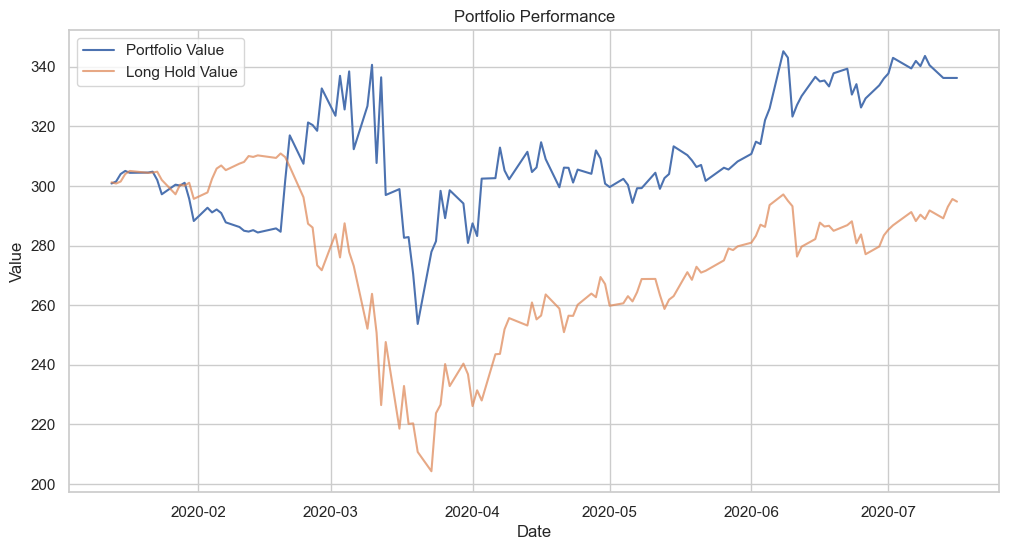

In [74]:
holdings = quant_df.iloc[0]["Close"] * 100
returns = []

for i in range(len(quant_df)):
    if i <= len(quant_df) - 4:
        today = quant_df.iloc[i]
        tmr = quant_df.iloc[i+1]
        day3 = quant_df.iloc[i+3]

        if today["Predictions"] == True:  # Bull market
            holdings *= (tmr["Close"]/today["Close"])

        elif today["Predictions"] == False:  # Bear market
            if holdings > 0:  # Sell 80% of holdings
                shortCapital = holdings * 0.8
                holdings *= 0.2

                holdings = holdings*(tmr["Close"]/today["Close"]) + shortCapital*(today["Close"]/day3["Close"])

    returns.append(holdings)

# Add returns to the DataFrame
quant_df["Portfolio Value"] = np.array(returns) / 100

print(f"Portfolio is {quant_df.iloc[-1]["Portfolio Value"] / quant_df.iloc[0]["Portfolio Value"] * 100:.4f}% after half a year.")
print(f"Long holding is {quant_df.iloc[-1]["Close"] / quant_df.iloc[0]["Close"] * 100:.4f}% after half a year.")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(quant_df["Date"], quant_df["Portfolio Value"], label="Portfolio Value")
plt.plot(quant_df["Date"], quant_df["Close"], label="Long Hold Value", alpha=0.7)
plt.title("Portfolio Performance")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

At last we can see our portfolio surpassed the base strategy significantly. We got 10% gross profit within 6 months, which our base strategy was hard to maintain itself.